<a href="https://colab.research.google.com/github/dante181111/awesomecucumber/blob/main/McDonalds%20Market%20segment%20python%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.linear_model import LinearRegression


In [ ]:
# Load the dataset (assuming it is in a CSV file for demonstration; replace with actual file path)
# If the dataset is not in a CSV file but in a different format or source, adjust accordingly.
mcdonalds = pd.read_csv("/content/mcdonalds.csv")

# Display column names
print(mcdonalds.columns.tolist())

# Display the dimensions of the dataset
print(mcdonalds.shape)

# Display the first 3 rows of the dataset
print(mcdonalds.head(3))


In [ ]:
MD_x = mcdonalds.iloc[:, 0:11]

# Convert "Yes" to 1 and "No" to 0
MD_x = (MD_x == "Yes").astype(int)

# Calculate column means and round to 2 decimal places
column_means = MD_x.mean().round(2)

# Print column means
print(column_means)

Data Preparation and PCA

In [ ]:
# Prepare data
MD_x = mcdonalds.iloc[:, 0:11]
MD_x = (MD_x == "Yes").astype(int)

# Calculate and print column means
column_means = MD_x.mean().round(2)
print("Column means:\n", column_means)

# Standardize the data
scaler = StandardScaler()
MD_x_scaled = scaler.fit_transform(MD_x)

# Perform PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x_scaled)

# Summarize PCA results
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Standard Deviation of Principal Components:\n", pca.singular_values_)
print("Proportion of Variance Explained:\n", explained_variance.round(4))
print("Cumulative Proportion of Variance Explained:\n", cumulative_variance.round(4))

loadings = pca.components_.T
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=MD_x.columns)
print("PCA Loadings:\n", loadings_df.round(2))


Column means:
 yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64
Standard Deviation of Principal Components:
 [63.91179298 48.69332668 44.78138456 39.63136078 36.52831435 33.7082743
 32.22832023 29.33600188 27.59057302 21.14107869 19.31862906]
Proportion of Variance Explained:
 [0.2556 0.1483 0.1255 0.0983 0.0835 0.0711 0.065  0.0538 0.0476 0.028
 0.0234]
Cumulative Proportion of Variance Explained:
 [0.2556 0.4039 0.5294 0.6277 0.7111 0.7822 0.8472 0.9011 0.9487 0.9766
 1.    ]
PCA Loadings:
              PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy      -0.41  0.28 -0.26  0.03  0.35 -0.12  0.16  0.02 -0.20  0.69 -0.09
convenient -0.31 -0.05 -0.32 -0.01 -0.44  0.19 -0.66  0.15 -0.34  0.03  0.02
spicy      -0.02  0.07  0.02  0.85 -0.19  0.44  0.21 -0.03  0.03  0.06 -0.04
fattening   0.18 -0

In [ ]:
loadings = pca.components_.T  # Transpose to match R's output format
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=MD_x.columns)
print(loadings_df.round(2))

# Project consumers into the first two principal components
pc_df = pd.DataFrame(MD_pca[:, :2], columns=['PC1', 'PC2'])

# Plot the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pc_df['PC1'], pc_df['PC2'], color='grey', alpha=0.5, label='Consumers')

# Add arrows for the original segmentation variables
for i, var in enumerate(MD_x.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, color='blue')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of McDonald\'s Data')
plt.grid(True)
plt.legend()
plt.show()

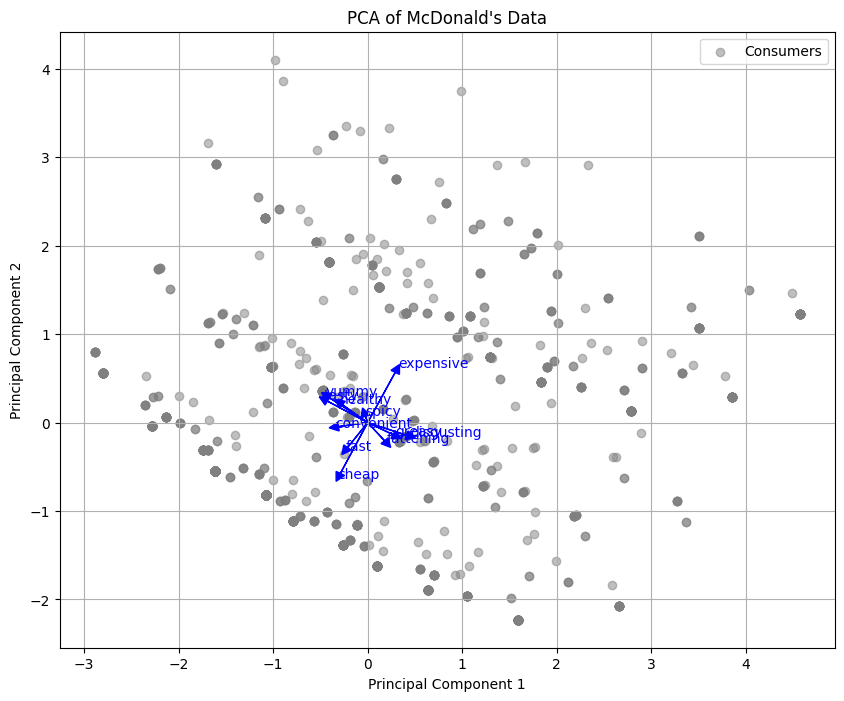

In [ ]:
# Plot the first two principal components
pc_df = pd.DataFrame(MD_pca[:, :2], columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 8))
plt.scatter(pc_df['PC1'], pc_df['PC2'], color='grey', alpha=0.5, label='Consumers')

for i, var in enumerate(MD_x.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, var, color='blue')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of McDonald\'s Data')
plt.grid(True)
plt.legend()
plt.show()


# **K means**

In [ ]:
# Function to perform k-means clustering
def perform_kmeans(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(X)
    return kmeans

# Perform k-means clustering
results = {}
for n_clusters in range(2, 9):
    kmeans = perform_kmeans(MD_x_scaled, n_clusters)
    results[n_clusters] = kmeans


In [ ]:
# Relabel clusters to ensure consistent cluster IDs
def relabel_clusters(results, X):
    all_labels = np.concatenate([kmeans.labels_ for kmeans in results.values()])
    unique_labels = np.unique(all_labels)
    relabeled_results = {}

    for n_clusters, kmeans in results.items():
        labels = np.arange(n_clusters)
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, kmeans.cluster_centers_)
        relabeled_labels = np.array([labels[closest[label]] for label in kmeans.labels_])
        relabeled_results[n_clusters] = relabeled_labels

    return relabeled_results

# Apply relabeling
relabelled_results = relabel_clusters(results, MD_x_scaled)

# Example: Access relabeled clusters for a specific number of clusters
n_clusters = 8
print(f"Relabeled clusters for {n_clusters} clusters:")
print(pd.Series(relabelled_results[n_clusters]).value_counts())


Relabeled clusters for 8 clusters:
0    352
3    228
7    190
5    188
4    166
1    115
6    114
2    100
Name: count, dtype: int64
